In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

df = pd.read_csv("cyber_atk_dataset.csv")
df.head()

,Timestamp,Source_IP,Destination_IP,Port,Protocol,Packet_Size,Duration,Attack_Type,Is_Attack,Packet_Loss,Latency,Throughput,Jitter,Authentication_Failure
0,2023-01-01 00:00:00,172.16.0.3,10.0.0.101,8002,UDP,783,69.673338,DoS,0,4.073125,103.388384,87.032649,47.660918,0
1,2023-01-01 01:00:00,192.168.1.4,172.16.0.102,4127,TCP,1201,70.244395,Data Injection,0,4.680815,244.054190,13.951388,25.885129,1
2,2023-01-01 02:00:00,192.168.1.1,192.168.1.100,1361,UDP,543,17.252221,APT,0,2.567589,439.247981,12.818457,40.973456,0
3,2023-01-01 03:00:00,172.16.0.3,192.168.1.100,8427,UDP,85,50.061264,Normal,1,4.751396,264.100320,17.649663,27.401669,0
4,2023-01-01 04:00:00,172.16.0.3,192.168.1.100,358,UDP,1436,41.254614,Malware,0,2.678445,465.005371,96.030609,2.135172,1


In [2]:

df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Hour"] = df["Timestamp"].dt.hour
df["Day"] = df["Timestamp"].dt.day
df.drop(columns=["Timestamp"], inplace=True)

cat_cols = ["Source_IP","Destination_IP","Protocol","Attack_Type"]
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=["Is_Attack"])

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
SEQ_LEN = 20

def create_sequences(data, seq_len):
    Xs = []
    for i in range(len(data) - seq_len):
        Xs.append(data[i:i+seq_len])
    return np.array(Xs)

X_seq = create_sequences(X_scaled, SEQ_LEN)


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

n_features = X_seq.shape[2]

inputs = Input(shape=(SEQ_LEN, n_features))

encoded = LSTM(64, activation="relu", return_sequences=False)(inputs)
decoded = RepeatVector(SEQ_LEN)(encoded)

decoded = LSTM(64, activation="relu", return_sequences=True)(decoded)
outputs = TimeDistributed(Dense(n_features))(decoded)

model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="mse")

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 20, 14)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 14)              │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,158 (211.55 KB)

 Trainable params: 54,158 (211.55 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
y = df["Is_Attack"].values

normal_mask = y[:-SEQ_LEN] == 0
X_train = X_seq[normal_mask]

model.fit(X_train, X_train, epochs=30, batch_size=32, validation_split=0.1)


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1842 - val_loss: 0.1212
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1137 - val_loss: 0.1034
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1030 - val_loss: 0.0985
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0978 - val_loss: 0.0960
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0958 - val_loss: 0.0943
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0949 - val_loss: 0.0937
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0943 - val_loss: 0.0933
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0940 - val_loss: 0.0936
Epoch 9/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0937 - val_loss: 0.0932
Epoch 10/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0934 - val_loss: 0.0927
Epoch 11/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0931 - val_loss: 0.0925
Epoch 12/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

In [6]:
X_pred = model.predict(X_seq)

recon_error = np.mean(np.abs(X_pred - X_seq), axis=(1,2))

threshold = np.percentile(recon_error, 95)

anomaly_pred = (recon_error > threshold).astype(int)

df["Predicted_Anomaly"] = np.concatenate([np.zeros(SEQ_LEN), anomaly_pred])


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [7]:
from sklearn.metrics import classification_report

print(classification_report(df["Is_Attack"][SEQ_LEN:], anomaly_pred))


              precision    recall  f1-score   support

           0       0.80      0.95      0.87       781
           1       0.20      0.05      0.08       199

    accuracy                           0.77       980
   macro avg       0.50      0.50      0.47       980
weighted avg       0.68      0.77      0.71       980



In [8]:
SENSOR_COL = "Source_IP"

SEQ_LEN = 20

def create_sequences(data, seq_len):
    Xs = []
    for i in range(len(data) - seq_len):
        Xs.append(data[i:i+seq_len])
    return np.array(Xs)

sensor_models = {}
sensor_scalers = {}

for sensor, group in df.groupby(SENSOR_COL):
    X = group.drop(columns=["Is_Attack"])

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_seq = create_sequences(X_scaled, SEQ_LEN)

    if len(X_seq) < 50:
        continue

    # LSTM autoencoder
    inputs = Input(shape=(SEQ_LEN, X_seq.shape[2]))
    encoded = LSTM(32, activation="relu")(inputs)
    decoded = RepeatVector(SEQ_LEN)(encoded)
    decoded = LSTM(32, activation="relu", return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(X_seq.shape[2]))(decoded)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")

    normal_mask = group["Is_Attack"].values[:-SEQ_LEN] == 0
    X_train = X_seq[normal_mask]

    history = model.fit(X_train, X_train, epochs=15, batch_size=16, verbose=0)

    sensor_models[sensor] = model
    sensor_scalers[sensor] = scaler


In [9]:
def realtime_predict(packet_df):
    packet_df["Hour"] = pd.to_datetime(packet_df["Timestamp"]).dt.hour
    packet_df["Day"] = pd.to_datetime(packet_df["Timestamp"]).dt.day
    packet_df.drop(columns=["Timestamp"], inplace=True)

    for col in cat_cols:
        packet_df[col] = encoders[col].transform(packet_df[col])

    results = []

    for sensor, group in packet_df.groupby(SENSOR_COL):
        if sensor not in sensor_models:
            continue

        X = group.drop(columns=["Is_Attack"])
        scaler = sensor_scalers[sensor]
        model = sensor_models[sensor]

        X_scaled = scaler.transform(X)
        X_seq = create_sequences(X_scaled, SEQ_LEN)

        if len(X_seq) == 0:
            continue

        recon = model.predict(X_seq, verbose=0)
        err = np.mean(np.abs(recon - X_seq), axis=(1,2))
        threshold = np.percentile(err, 95)

        anomaly_flag = (err > threshold).astype(int)

        results.extend(anomaly_flag)

    return results


In [10]:
from sklearn.ensemble import RandomForestClassifier

X_rf = df.drop(columns=["Is_Attack"])
X_rf_scaled = MinMaxScaler().fit_transform(X_rf)

rf = RandomForestClassifier(n_estimators=200, class_weight="balanced")
rf.fit(X_rf_scaled, df["Is_Attack"])


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [11]:
rf_pred = rf.predict(X_rf_scaled)

lstm_pred = df["Predicted_Anomaly"].values

final_pred = np.logical_or(rf_pred, lstm_pred).astype(int)

df["Final_Anomaly"] = final_pred

In [12]:
from sklearn.metrics import classification_report
print(classification_report(df["Is_Attack"], df["Final_Anomaly"]))


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       798
           1       0.84      1.00      0.91       202

    accuracy                           0.96      1000
   macro avg       0.92      0.98      0.94      1000
weighted avg       0.97      0.96      0.96      1000



In [13]:
comparison = pd.DataFrame({
    "Actual_Attack": df["Is_Attack"],
    "Predicted_Attack": df["Final_Anomaly"]
})

print("\nACTUAL vs PREDICTED TABLE\n")
print(comparison.head(20))



ACTUAL vs PREDICTED TABLE

    Actual_Attack  Predicted_Attack
0               0                 0
1               0                 0
2               0                 0
3               1                 1
4               0                 0
5               0                 0
6               0                 0
7               0                 0
8               0                 0
9               0                 0
10              0                 0
11              0                 0
12              1                 1
13              1                 1
14              0                 0
15              0                 0
16              0                 0
17              0                 0
18              0                 0
19              0                 0


In [14]:
print("\nONLY ATTACK DETECTIONS\n")
print(comparison[comparison["Actual_Attack"] == 1].head(20))


ONLY ATTACK DETECTIONS

     Actual_Attack  Predicted_Attack
3                1                 1
12               1                 1
13               1                 1
20               1                 1
26               1                 1
34               1                 1
44               1                 1
48               1                 1
61               1                 1
62               1                 1
63               1                 1
73               1                 1
76               1                 1
81               1                 1
86               1                 1
91               1                 1
97               1                 1
99               1                 1
104              1                 1
117              1                 1


In [15]:
attack_df = df[df["Final_Anomaly"] == 1].copy()

attack_json = attack_df.to_dict(orient="records")

import json
print(json.dumps(attack_json[:10], indent=2))

[
  {
    "Source_IP": 1,
    "Destination_IP": 2,
    "Port": 8427,
    "Protocol": 2,
    "Packet_Size": 85,
    "Duration": 50.06126393245504,
    "Attack_Type": 4,
    "Is_Attack": 1,
    "Packet_Loss": 4.751396118057035,
    "Latency": 264.1003198253879,
    "Throughput": 17.649662567061597,
    "Jitter": 27.401669364188137,
    "Authentication_Failure": 0,
    "Hour": 3,
    "Day": 1,
    "Predicted_Anomaly": 0.0,
    "Final_Anomaly": 1
  },
  {
    "Source_IP": 1,
    "Destination_IP": 0,
    "Port": 5339,
    "Protocol": 2,
    "Packet_Size": 759,
    "Duration": 14.369912284951754,
    "Attack_Type": 1,
    "Is_Attack": 1,
    "Packet_Loss": 2.017599962201056,
    "Latency": 471.7117458252007,
    "Throughput": 63.21430688091026,
    "Jitter": 46.13269492549491,
    "Authentication_Failure": 0,
    "Hour": 12,
    "Day": 1,
    "Predicted_Anomaly": 0.0,
    "Final_Anomaly": 1
  },
  {
    "Source_IP": 1,
    "Destination_IP": 1,
    "Port": 6629,
    "Protocol": 0,
    "Packet

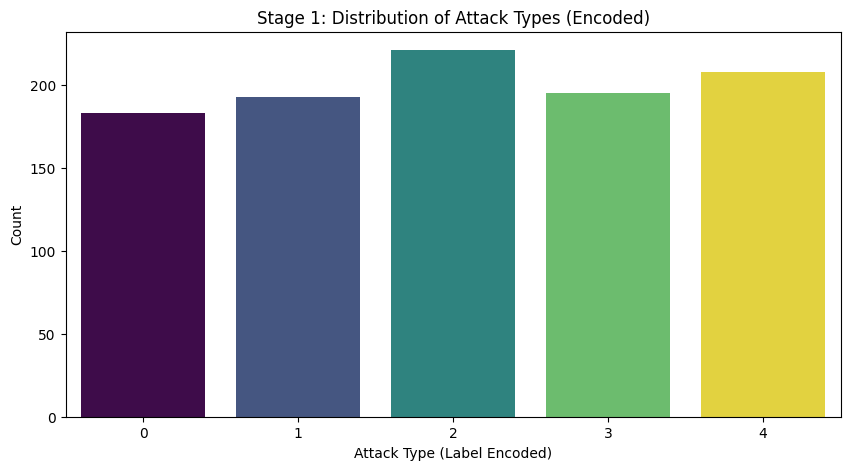

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- STAGE 1: Dataset Distribution (Corrected) ---
plt.figure(figsize=(10, 5))

sns.countplot(
    x=df["Attack_Type"],
    hue=df["Attack_Type"],  # <--- Assign the x variable to hue
    palette="viridis",
    legend=False            # <--- Disable the redundant legend
)

plt.title("Stage 1: Distribution of Attack Types (Encoded)")
plt.xlabel("Attack Type (Label Encoded)")
plt.ylabel("Count")
plt.savefig(f"plot_{pd.Timestamp.now().strftime('%H%M%S')}.png", bbox_inches='tight')
plt.show()

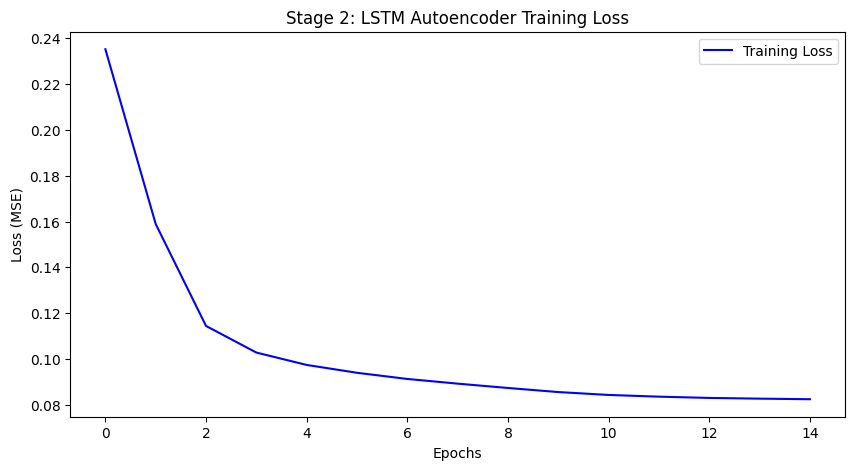

In [18]:
# --- STAGE 2: LSTM Training Loss ---
# Ensure you captured history: history = model.fit(...)
if 'history' in locals():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title("Stage 2: LSTM Autoencoder Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.show()
else:
    print("Skipping Loss Plot: 'history' variable not found. Assign 'history = model.fit(...)'")

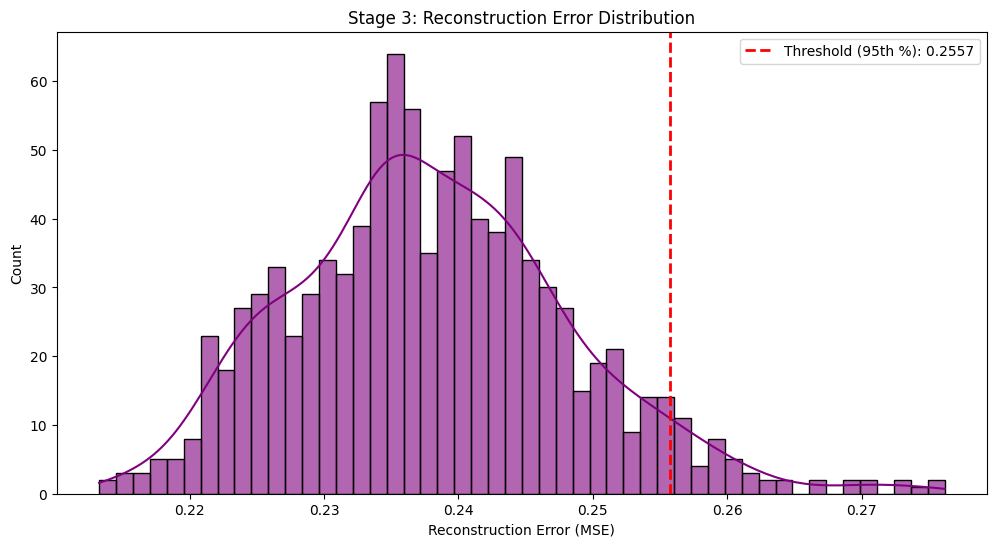

In [19]:

# --- STAGE 3: Reconstruction Error & Threshold ---
plt.figure(figsize=(12, 6))
sns.histplot(recon_error, bins=50, kde=True, color='purple', alpha=0.6)
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold (95th %): {threshold:.4f}')
plt.title("Stage 3: Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error (MSE)")
plt.legend()
plt.show()

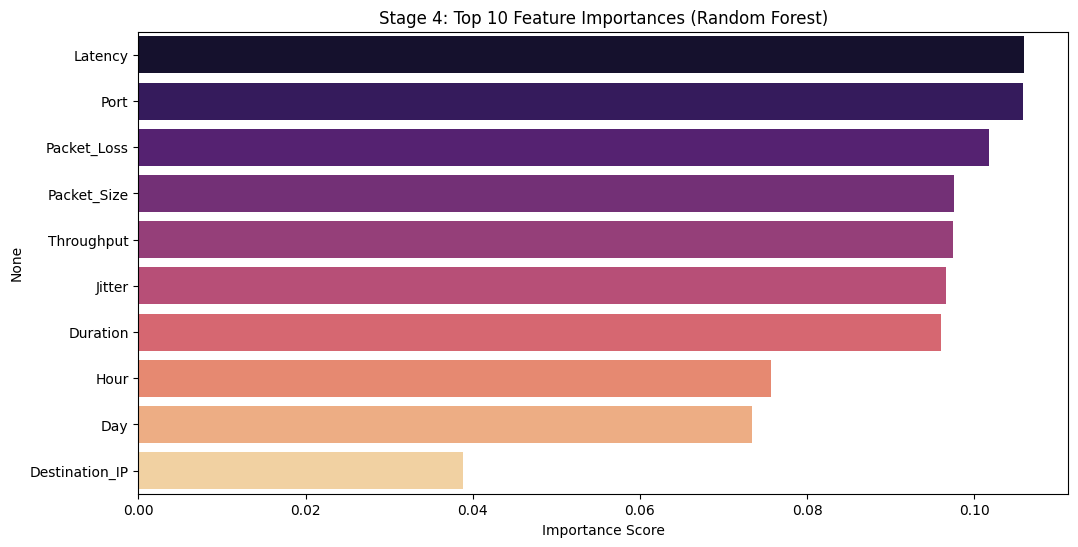

In [20]:
# --- STAGE 4: Random Forest Feature Importance (Corrected) ---
if 'rf' in locals() and 'X_rf' in locals():
    plt.figure(figsize=(12, 6))
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X_rf.columns

    # FIX: Added 'hue' and 'legend=False' to satisfy the new seaborn syntax
    sns.barplot(
        x=importances[indices][:10],
        y=features[indices][:10],
        hue=features[indices][:10],  # <--- This fixes the warning
        palette="magma",
        legend=False
    )
    plt.title("Stage 4: Top 10 Feature Importances (Random Forest)")
    plt.xlabel("Importance Score")
    plt.show()

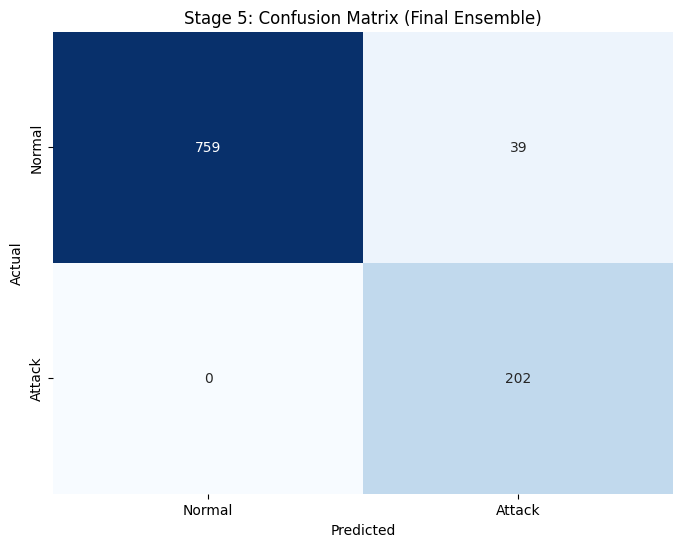

In [21]:
# --- STAGE 5: Final Evaluation (Confusion Matrix) ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(df["Is_Attack"], df["Final_Anomaly"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Stage 5: Confusion Matrix (Final Ensemble)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [23]:
import json
import pandas as pd
import random
import networkx as nx

# ==========================================
# PART 3: ANIMATED GRAPH DATA EXPORT
# ==========================================
print("\n[INFO] Processing Data for Animated Graph...")

# 1. DATA SELECTION
# ------------------------------------------
# Select only confirmed anomalies (Attacks)
# We sort by index to keep the temporal order
viz_df = df[df["Final_Anomaly"] == 1].copy()

# Limit to last 150 attacks to ensure the browser animation stays smooth
if len(viz_df) > 150:
    viz_df = viz_df.tail(150)

# 2. IP ADDRESS DECODING / GENERATION
# ------------------------------------------
# The goal: Ensure every node has a cool-looking IP (e.g., "192.168.X.X") 
# instead of just "0" or "1".
unique_ids = set(viz_df['Source_IP']).union(set(viz_df['Destination_IP']))
ip_map = {}

for uid in unique_ids:
    # Option A: Try to use your real encoders if they exist
    if 'encoders' in locals() and "Source_IP" in encoders:
        try:
            original = encoders["Source_IP"].inverse_transform([int(uid)])[0]
            ip_map[uid] = str(original)
        except:
            # Fallback if specific ID fails
            ip_map[uid] = f"192.168.0.{int(uid)}"
    # Option B: Generate deterministic "Hacker-style" IPs
    else:
        random.seed(int(uid)) # Seed ensures ID 5 always gets the same fake IP
        # Generate random subnets for variety (10.x.x.x or 192.168.x.x)
        if random.random() > 0.5:
            ip_map[uid] = f"192.168.{random.randint(0,50)}.{int(uid) % 255}"
        else:
            ip_map[uid] = f"10.{random.randint(0,255)}.{random.randint(0,255)}.{random.randint(1,254)}"

# 3. BUILD JSON STRUCTURE
# ------------------------------------------
nodes = {}
links = []

for idx, row in viz_df.iterrows():
    src_id = row['Source_IP']
    dst_id = row['Destination_IP']
    
    src_label = ip_map.get(src_id, f"Unknown_{src_id}")
    dst_label = ip_map.get(dst_id, f"Unknown_{dst_id}")
    
    # Color Logic based on Attack Type
    # 0: DoS (Red), 1: Malware (Purple), 2: Brute Force (Orange), etc.
    atk_type = int(row.get('Attack_Type', 0))
    # Neon palette
    colors = ["#ff0055", "#d303fc", "#fc8403", "#00ff41", "#0388fc"] 
    color = colors[atk_type % len(colors)]
    
    # Add Nodes (Upsert logic)
    if src_label not in nodes:
        nodes[src_label] = {"id": src_label, "group": "Attacker", "val": 10}
    else:
        nodes[src_label]["val"] += 2 # Grow node if it attacks more
        
    if dst_label not in nodes:
        nodes[dst_label] = {"id": dst_label, "group": "Target", "val": 5}
    else:
        nodes[dst_label]["val"] += 1 # Grow node if it gets hit more

    # Add Link (The Animation Data)
    links.append({
        "source": src_label,
        "target": dst_label,
        "color": color,            # Line color
        "particles": 4,            # Number of glowing dots
        "speed": float(row['Packet_Size']) * 0.0001 + 0.001, # Speed based on data size
        "info": f"Type: {atk_type} | Pkt: {row['Packet_Size']}"
    })

# Convert nodes dict to list
graph_data = {
    "nodes": list(nodes.values()),
    "links": links
}

# 4. SAVE JSON FILE
# ------------------------------------------
with open("cyber_graph_data.json", "w") as f:
    json.dump(graph_data, f, indent=4)

print(f"[SUCCESS] Exported {len(links)} attack vectors to 'cyber_graph_data.json'")


[INFO] Processing Data for Animated Graph...
[SUCCESS] Exported 150 attack vectors to 'cyber_graph_data.json'
